In [1]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input ,Dense ,Dropout ,LayerNormalization ,Softmax ,LeakyReLU
from keras import Model
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [2]:
# prepration
data =load_iris(return_X_y =True) 
x_norm =(data[0] /np.max(data[0] ,axis =0)).astype(np.float32)
label =data[1].reshape(-1,1).astype(np.int32)
xtr ,xte ,ytr ,yte =train_test_split(x_norm ,label ,test_size =0.2)
cols =['length' ,'width' ,'sepals' ,'petals']
x_frame =pd.DataFrame(data[0] ,columns =cols ,dtype =np.float32)

print('data_show :')
print('=======================================================')
print(x_frame.head(10) ,'\n')
print('features_describe :')
print('=======================================================')
print(x_frame.describe())

data_show :
   length  width  sepals  petals
0     5.1    3.5     1.4     0.2
1     4.9    3.0     1.4     0.2
2     4.7    3.2     1.3     0.2
3     4.6    3.1     1.5     0.2
4     5.0    3.6     1.4     0.2
5     5.4    3.9     1.7     0.4
6     4.6    3.4     1.4     0.3
7     5.0    3.4     1.5     0.2
8     4.4    2.9     1.4     0.2
9     4.9    3.1     1.5     0.1 

features_describe :
           length       width      sepals      petals
count  150.000000  150.000000  150.000000  150.000000
mean     5.843333    3.057333    3.758000    1.199333
std      0.828066    0.435866    1.765298    0.762238
min      4.300000    2.000000    1.000000    0.100000
25%      5.100000    2.800000    1.600000    0.300000
50%      5.800000    3.000000    4.350000    1.300000
75%      6.400000    3.300000    5.100000    1.800000
max      7.900000    4.400000    6.900000    2.500000


In [ ]:
# model definition
def create_model(drate ,nslop ,lr): 
    input =Input(shape =(4,))
    dense1 =Dense(units =1024)(input)
    norm1 =LayerNormalization()(dense1) 
    act1 =LeakyReLU(negative_slope =nslop)(norm1) 
    drop1 =Dropout(rate =drate)(act1) 
    dense2 =Dense(units =512)(drop1)
    norm2 =LayerNormalization()(dense2) 
    act2 =LeakyReLU(negative_slope =nslop)(norm2) 
    drop2 =Dropout(rate =drate)(act2)
    dense3 =Dense(units =256)(drop2)
    norm3 =LayerNormalization()(dense3) 
    act3 =LeakyReLU(negative_slope =nslop)(norm3) 
    drop3 =Dropout(rate =drate)(act3)
    dense4 =Dense(units =128)(drop3)
    norm4 =LayerNormalization()(dense4) 
    act4 =LeakyReLU(negative_slope =nslop)(norm4) 
    drop4 =Dropout(rate =drate)(act4)
    dense5 =Dense(units =64)(drop4)
    norm5 =LayerNormalization()(dense5) 
    act5 =LeakyReLU(negative_slope =nslop)(norm5) 
    drop5 =Dropout(rate =drate)(act5)
    dense6 =Dense(units =32)(drop5)
    norm6 =LayerNormalization()(dense6) 
    act6 =LeakyReLU(negative_slope =nslop)(norm6) 
    drop6 =Dropout(rate =drate)(act6)
    dense7 =Dense(units =16)(drop6)
    norm7 =LayerNormalization()(dense7) 
    act7 =LeakyReLU(negative_slope =nslop)(norm7) 
    drop7 =Dropout(rate =drate)(act7)
    dense8 =Dense(units =3)(drop7)
    norm8 =LayerNormalization()(dense8) 
    act8 =Softmax()(norm8) 
    model =Model(inputs =input ,outputs =act8)
    model.compile(optimizer =Adam(learning_rate =lr) ,loss =SparseCategoricalCrossentropy)
    return model

In [ ]:
# grid search cross validation 
modelCV =KerasClassifier(model =create_model ,
                         loss =SparseCategoricalCrossentropy ,
                         optimizer =Adam(learning_rate=0.001) ,
                         epochs =10 ,
                         batch_size =64 ,
                         verbose =0
                        )
params ={ 
    'model__drate' :[0.4 ,0.5] ,
    'model__nslop' :[0.2 ,0.3] ,
    'model__lr':[0.002 ,0.003]
}
gs =GridSearchCV(modelCV ,params ,cv =4)
gs_result =gs.fit(xtr ,ytr)
best_params =gs_result.best_params_
model =create_model(best_params['model__drate'] ,best_params['model__nslop'] ,best_params['model__lr'])
print(f'best_estimate_params : {best_params}')

In [ ]:
# model training 
epoch =200
batch_size =64
fpath ='checkpoint.weights.h5'
c_point =keras.callbacks.ModelCheckpoint(filepath =fpath ,monitor ='val_loss' ,mode ='min' ,save_weights_only =True ,save_best_only =True)
early_stoping =keras.callbacks.EarlyStopping(monitor ='val_loss' ,patience =60 ,restore_best_weights =True)
train =model.fit(xtr ,ytr ,epochs =epoch ,batch_size =batch_size ,validation_data =(xte ,yte) ,callbacks =[early_stoping ,c_point] ,verbose =2)

In [30]:
# model evalulation
Y =model.predict(xte) 
Yte =[]
for predict in Y : 
  lbl =np.where(predict ==np.max(predict))[0][0]
  Yte.append(lbl)
Yte =np.asarray(Yte).reshape(-1,1)
test_acc_per =accuracy_score(y_true =yte ,y_pred =Yte) *100
print(f'accuracy_score_for_test_data : {test_acc_per} %')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
accuracy_score_for_test_data : 96.66666666666667 %


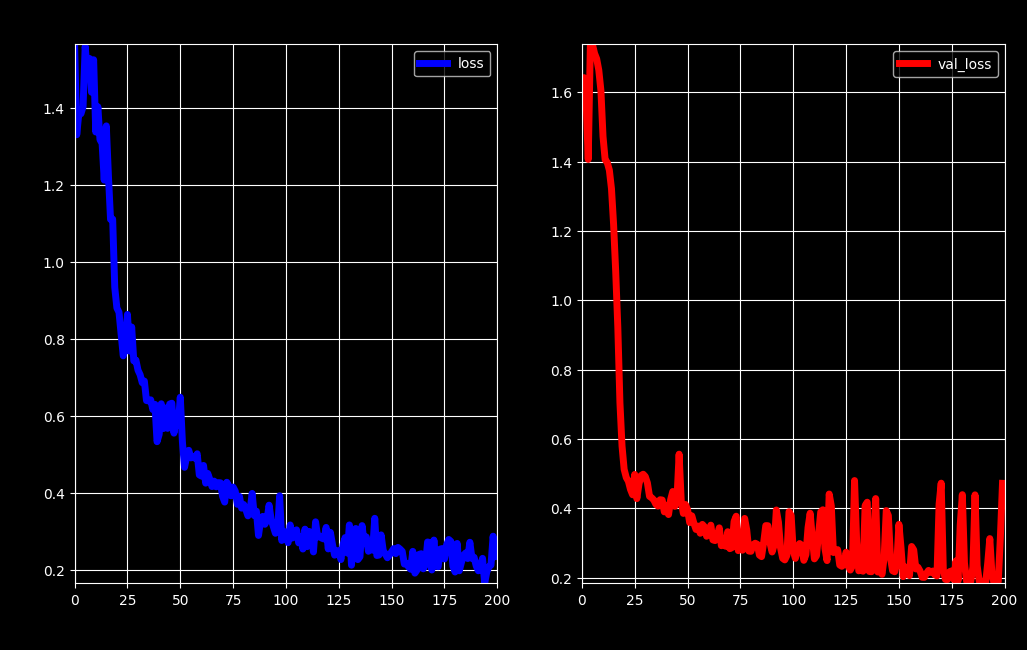

In [ ]:
# evaluation plot
def font_config(family ,color ,weight ,style ,size) : 
    return {'family': family,
        'color':  color,
        'weight': weight,
        'style' : style,
        'size': size
        }
plt.style.use('dark_background')
plt.figure(num =1 ,figsize =(12,7) ,dpi =100)
font_title =font_config('serif' ,'black' ,'normal' ,'italic' ,20)
font_label =font_config('serif' ,'black' ,'normal' ,'italic' ,15)
plt.subplot(121)
plt.plot(train.history['loss'] ,color ='blue' ,lw =5  ,label ='loss')
plt.xlim((0 ,epoch))
plt.ylim((np.min(train.history['loss']) ,np.max(train.history['loss'])))
plt.xlabel(xlabel ='epochs' ,labelpad =10 ,loc ='right' ,fontdict =font_label)
plt.ylabel(ylabel ='loss' ,labelpad =10 ,loc ='top' ,fontdict =font_label)
plt.title(label ='loss plot' ,pad =10 ,fontdict =font_title)
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(train.history['val_loss'] ,color ='red' ,lw =5  ,label ='val_loss')
plt.xlim((0 ,epoch))
plt.ylim((np.min(train.history['val_loss']) ,np.max(train.history['val_loss'])))
plt.xlabel(xlabel ='epochs' ,labelpad =10 ,loc ='right' ,fontdict =font_label)
plt.ylabel(ylabel ='val_loss' ,labelpad =10 ,loc ='top' ,fontdict =font_label)
plt.title(label ='val_loss plot' ,pad =10 ,fontdict =font_title)
plt.grid()
plt.legend()
plt.show()